## Libraries

In [1]:
### Load Libraries and Functions
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

from collections import Counter

from _cm import lambda_path, eln, bss, crr, dtr, candidate_models, candidate_models_kf
from _fm import bssf_cv, fss_cv, lasso_cv, csr_cv, avg_best_cv, pelasso_cv, psgd_cv
from _helpers import relevant_predictor, run_results
from _visualization import plot_subsetsize, plot_cm, plot_preds

import gurobipy as gp
gp.setParam('OutputFlag', 0)

if os.name == 'nt':
    import dill
    dill.settings['recurse'] = True

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-10


In [2]:
# Set Path
path  =  os.path.dirname(os.getcwd())

## Application: Eye-Gene-Data

In [3]:
### Parameter
# Setting
N = 3
train = 60
ran_st = 123
timeout = 10
alpha = 1e6

# Candidate Models
cm_params = [
    ("bss", {"k_vec": np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]), "n_jobs": 1}),
    #("eln", {"n_lambda": 20, "alpha_vec": np.array([0.0, 0.25, 0.50, 0.75, 1.00]), "n_jobs": 1}),
    #("crr", {"comp_vec": np.array([1, 2, 3, 4, 5]), "rep_range": np.arange(1, 501), "n_jobs": 1}),
    ("dtr", {"vec_depth": np.array([2, 3, 4, 5]), "n_jobs": 1}),
    #("dtrst", {"n_jobs": 1}),
]

In [4]:
# Load Eye Data
X = pd.read_csv(path + '/data/eye_x.csv')
y = pd.read_csv(path + '/data/eye_y.csv')

# Convert to Numpy
X = X.to_numpy()
y = y.to_numpy().ravel()

In [5]:
# Run Results
results = run_results(N, X, y, train, cm_params, timeout, alpha, ran_st)

# Save Results
filename = f"{path}/Results/Application/eye_results.pkl"
with open(filename, 'wb') as f:
    pickle.dump(results, f)

Iteration: 1
Iteration: 2
Iteration: 3


In [7]:
# Load Results
filename = f"{path}/Results/Application/eye_results.pkl"
with open(filename, 'rb') as file:
    results = pickle.load(file)

# Assign Results
preds = results['predictions']
scores = results['mse']
best_k = results['best_k']
bssf_weights = results['bssf_weights']
cf_models = results['cf_models']
cf_descriptions = results['cf_descriptions']
model_names = results['fmodel_names']
bssf_timeout = results['bssf_timeout']
bssf_alpha = results['bssf_alpha']
runs = len(results['predictions'])
numb_cm = len(cf_models[0])

# Relative to BSSF
relative_scores = np.round(np.mean(scores, axis = 0) / np.mean(scores, axis = 0)[6], 4)

# 
print(f"Setting: N={runs}, Type=Application, CM={numb_cm}, alpha={bssf_alpha}, timeout={bssf_timeout}")

# Show
model_scores = {model: score for model, score in zip(model_names, relative_scores)}
model_scores

Setting: N=3, Type=Application, CM=19, alpha=1000000.0, timeout=10


{'PHM': 1.5587,
 'LASSO': 0.8415,
 'PELASSO': 0.9606,
 'AVG_BEST': 0.9834,
 'CSR': 0.9173,
 'PSGD': 1.1137,
 'BSSF': 1.0}

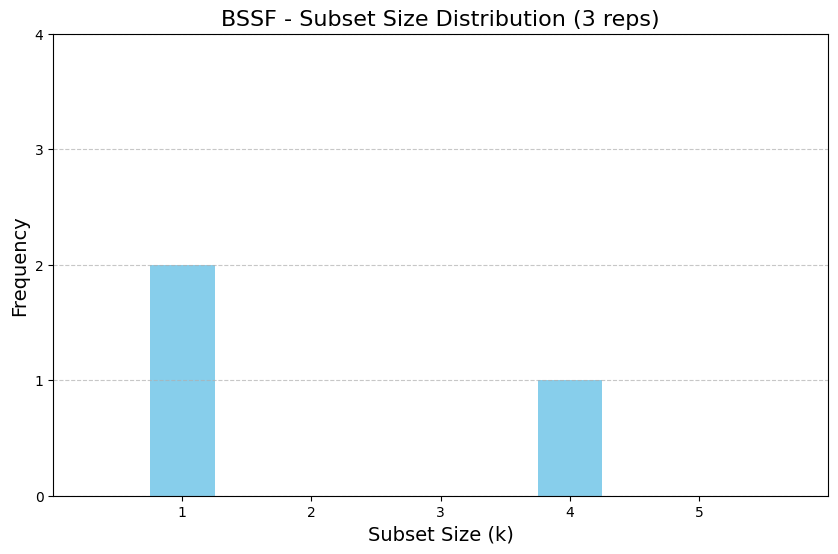

In [8]:
# Plot Subset-Size
plot_subsetsize(best_k, 5, runs)

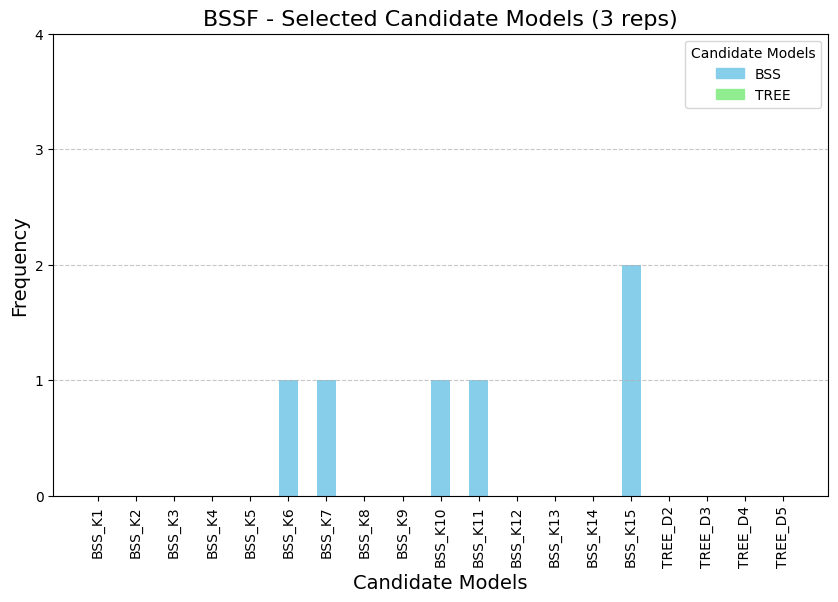

In [9]:
# Plot Selected Candidate Models
plot_cm(bssf_weights, cf_descriptions, runs)

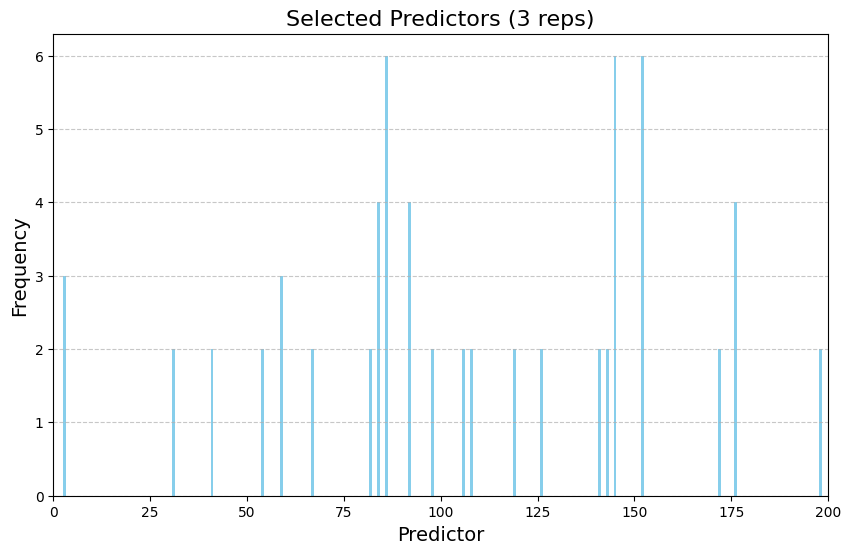

In [10]:
# Plot Selected Predictiors
plot_preds(cf_models, bssf_weights, 200, runs)

---

---

In [ ]:
### Application: Eye Data
def application(N, x, y, train, cm_params, ran_st):
    """
    Function for real data analysis simulation.
    
    Parameters:
    - N: Number of simulations.
    - x: DataFrame of predictors.
    - y: Series or array of response variable.
    - train: Number of observations to include in the training set.
    - cm_params: List of tuples with the candidate models and their parameters.
    - ran_st: Seed for random number generator 
    
    Returns:
    - output_pred: List of predictions for each model.
    - output_mse: List of mean squared errors for each model.
    - output_bestk: List of best k values for each model.
    - output_weights: List of weights for BSSF model.
    - output_cfmodels: List of candidate models.
    - ...
    - fmodel_names: List of model names.
    """
    
    # Forecasting Model Names
    fmodel_names = ["PHM", "LASSO", "PELASSO", "AVG_BEST", "CSR", "PSGD", "BSSF"]
    
    # Set seed for reproducibility
    np.random.seed(ran_st)
    
    # Full Index 
    indices = np.arange(0, x.shape[0])
    
    # Train Indices
    full_train_indices = [np.random.choice(indices, train, replace = False) for _ in range(N)]
        
    # Output list
    output_pred = []
    output_mse = []
    output_bestk = []
    output_weights = []
    output_cfmodels = []
    
    # Simulation replications
    for rep_ind, train_indices in enumerate(full_train_indices, start=1):
        
        # Iteration printing
        print(f"Iteration: {rep_ind}")
        
        # Test indices
        test_indices = np.setdiff1d(indices, train_indices)
        
        # Train-Test-Split
        x_train = x[train_indices].copy()
        y_train = y[train_indices].copy()
        x_test = x[test_indices].copy()
        y_test = y[test_indices].copy()
        
        # Check
        assert x_train.shape[0] == y_train.shape[0]
        assert x_test.shape[0] == y_test.shape[0]
        assert x_train.shape[0] == train
        
        ## Candidate Models
        lambda_vec = None
        kfolds = train ### kfolds = train denotes LOOCV
        
        # Candidate models -- Train
        target_train, cf_train, lambda_vec = candidate_models_kf(y_train, x_train, kfolds, cm_params, ran_st = rep_ind, n_jobs = 5)
        
        # Candidate models -- Test
        cf_models, cf_test, cf_descriptions = candidate_models(y_train, x_train, x_test, cm_params, lambda_vec)
        
        # Check
        assert cf_train.shape[0] == x_train.shape[0]
        assert cf_test.shape[0] == x_test.shape[0]
        assert cf_train.shape[0] == train
        
        ### Benchmark Methods
        kfolds = 5
        
        # PHM
        pred_phm = np.full(y_test.shape[0], target_train.mean())
        
        ## Forward Stepwise Regression
        #pred_fss, fss_k = fss_cv(y_train, x_train, x_test, kfolds, n_jobs = 4)
        
        # Lasso
        pred_lasso, lasso_coef, lasso_k = lasso_cv(y_train, x_train, x_test, kfolds, n_jobs = 4)
        
        # peLasso
        pred_pelasso, pelasso_coef, pelasso_k = pelasso_cv(target_train, cf_train, cf_test, kfolds, n_jobs = 4)
        
        # Best Average
        vec_k = np.array([1, 2, 3, 4, 5])
        pred_avg_best, avg_best_k = avg_best_cv(target_train, cf_train, cf_test, vec_k, kfolds, ran_st = rep_ind, n_jobs = 1)
        
        # Complete Subset Regression
        vec_k = np.arange(1, 10)
        sampling = True
        pred_csr, csr_k = csr_cv(y_train, x_train, x_test, vec_k, sampling, kfolds, ran_st = rep_ind, n_jobs = 4)
                
        # Fast-Best-Split-Selection - Simple Signals
        n_models = 5
        split_grid = np.array([1, 2, 3, 4, 5])
        size_grid = np.array([9, 12, 15]) # np.floor(np.array([0.3 * x_train.shape[0], 0.4 * x_train.shape[0], 0.5 * x_train.shape[0]]))
        pred_psgd, psgd_coef, psgd_k = psgd_cv(y_train, x_train, x_test, n_models, split_grid, size_grid, kfolds, n_jobs = 4)
                
        # BSSF
        alpha = 1e6
        vec_k = np.array([1, 2, 3, 4, 5])
        timeout = 5.0
        method = "gurobi"
        pred_bssf, bssf_weights, bssf_k = bssf_cv(target_train, cf_train, cf_test, alpha, vec_k, timeout, method, kfolds, ran_st = rep_ind)
        
        ### Evaluation
        # MSE
        mse_phm = np.mean((y_test - pred_phm)**2)
        #mse_fss = np.mean((y_test - pred_fss)**2)
        mse_lasso = np.mean((y_test - pred_lasso)**2)
        mse_pelasso = np.mean((y_test - pred_pelasso)**2)
        mse_avg_best = np.mean((y_test - pred_avg_best)**2)
        mse_csr = np.mean((y_test - pred_csr)**2)
        mse_psgd = np.mean((y_test - pred_psgd)**2)
        mse_bssf = np.mean((y_test - pred_bssf)**2)            

        # Append Results
        output_pred.append([y_test, pred_phm, pred_lasso, pred_pelasso, pred_avg_best, pred_csr, pred_psgd, pred_bssf])
        output_mse.append([mse_phm, mse_lasso, mse_pelasso, mse_avg_best, mse_csr, mse_psgd, mse_bssf])
        output_bestk.append([None, lasso_k, pelasso_k, avg_best_k, csr_k, psgd_k, bssf_k])
        output_weights.append(bssf_weights)
        output_cfmodels.append(cf_models)
    
    return output_pred, output_mse, output_bestk, output_weights, output_cfmodels, cf_descriptions, fmodel_names

In [ ]:
### Frequency Distribution of BSSF Subset-Size (k)
# Extract BSSF Subset-Size (k)
bssf_k = [lst[-1] for lst in best_k]

# Count the frequency of each element in bssf_k
freq = Counter(bssf_k)

# Create a bar plot for the frequency distribution
plt.figure(figsize=(10, 6))
plt.bar(freq.keys(), freq.values(), color='skyblue', width = 0.75)
plt.xlabel('k', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'BSSF - Subset Size ({N} reps)', fontsize=16)
plt.xlim(0, 10)
plt.xticks(range(0, 11))
plt.ylim(0, N)
plt.yticks(range(0, N+1))
#plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Plot selected Candidate Models
# Sum over repetitions
sum_bssf_weights = np.sum(bssf_weights, axis=0)

# Get model names and frequencies
model_names = cf_descriptions
frequencies = [sum_bssf_weights[i] for i in range(len(model_names))]

# Define color mapping
group_colors = {
    #'ELN': 'blue',
    'BSS': 'skyblue',
    #'LARS': 'darkblue',
    #'CRR': 'green',
    'TREE': 'lightgreen',
    'TREEST': 'lightcoral',
    # Add more ...
}

# Extract groups from model names and assign colors
colors = []
for name in model_names:
    group = name.split('_')[0]
    color = group_colors.get(group, 'gray')
    colors.append(color)

# Create a bar plot for the frequency distribution
plt.figure(figsize=(10, 6))
plt.bar(model_names, frequencies, color=colors, width=0.5)
plt.xlabel('Candidate Models', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'BSSF - Selected Candidate Models ({N} reps)', fontsize=16)
plt.ylim(0, N)
plt.yticks(range(0, N+1))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create custom legend
legend_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
plt.legend(handles=legend_patches, title='Candidate Models')

plt.show()

### Relevant Predictors
# Extract relevant predictors
idx = relevant_predictor(cf_models, bssf_weights)
list_idx = [idx for sublist in idx.values() for idx in sublist]

# Count the frequency of each element in bssf_k
freq = Counter(list_idx)

# Create a bar plot for the frequency distribution
plt.figure(figsize=(10, 6))
plt.bar(freq.keys(), freq.values(), color='skyblue', width = 0.75)
plt.xlabel('Predictor', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Selected Predictors ({N} reps)', fontsize=16)
plt.xlim(0, 200)
#plt.xticks(range(0, 201))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---

In [ ]:
###### File for Candidate Model Functions ######
### Import
import numpy as np
#import pandas as pd
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn import random_projection
from sklearn.model_selection import KFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lars
import statsmodels.api as sm
from abess.linear import LinearRegression as abessLR
#from itertools import combinations